In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [3]:
labels_df = pd.read_csv('/kaggle/input/nih-balanced-and-resized-chest-x-rays/new_labels.csv')
labels_df.head()

Path  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0  00000001_000.png            0             1              0      0   
1  00000001_001.png            0             1              0      0   
2  00000001_002.png            0             1              0      0   
3  00000002_000.png            0             0              0      0   
4  00000003_000.png            0             0              0      0   

   Effusion  Emphysema  Fibrosis  Hernia  Infiltration  Mass  No Finding  \
0         0          0         0       0             0     0           0   
1         0          1         0       0             0     0           0   
2         1          0         0       0             0     0           0   
3         0          0         0       0             0     0           1   
4         0          0         0       1             0     0           0   

   Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0       0                   0          0             0  
1       0                   0          0             0  
2       0                   0          0             0  
3       0                   0          0             0  
4       0                   0          0             0

In [5]:
sampled_df = labels_df.sample(n=5100, random_state=42)

In [6]:
disease_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
                   'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 
                   'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [7]:
train_df, temp_df = train_test_split(sampled_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [8]:
image_dir = '/kaggle/input/nih-balanced-and-resized-chest-x-rays/resized_images/resized_images'
img_size = 256  # Images are 256x256 grayscale

In [14]:
# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='Path',
    y_col=disease_columns,
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32
)


Found 4080 validated image filenames.
Found 510 validated image filenames.
Found 510 validated image filenames.


In [27]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-40:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(disease_columns), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy',
            AUC(multi_label=True, num_labels=len(disease_columns), name='auc')
            ]
)

In [28]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=110,
    batch_size=8,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/110
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.0524 - auc: 0.5039 - loss: 0.8239
Epoch 1: val_loss improved from inf to 0.62655, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 782ms/step - accuracy: 0.0524 - auc: 0.5040 - loss: 0.8234 - val_accuracy: 0.0608 - val_auc: 0.5175 - val_loss: 0.6266
Epoch 2/110
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.0550 - auc: 0.5293 - loss: 0.6259
Epoch 2: val_loss improved from 0.62655 to 0.52096, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 68s 501ms/step - accuracy: 0.0550 - auc: 0.5294 - loss: 0.6256 - val_accuracy: 0.0608 - val_auc: 0.5451 - val_loss: 0.5210
Epoch 3/110
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.0590 - auc: 0.5559 - loss: 0.5014
Epoch 3: val_loss improved from 0.52096 to 0.44058, saving model to best_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 68s 502ms/step - accuracy: 0.0590 - auc: 0.5559 - loss: 0.5012 - val_accuracy: 0.0588 - val_auc: 0.5678 - 

In [29]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

train_features = feature_extractor.predict(train_generator, verbose=1)
val_features = feature_extractor.predict(val_generator, verbose=1)
test_features = feature_extractor.predict(test_generator, verbose=1)

train_labels = train_generator.labels
val_labels = val_generator.labels
test_labels = test_generator.labels

128/128 ━━━━━━━━━━━━━━━━━━━━ 85s 568ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


In [30]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset, ClassifierChain
from sklearn.metrics import classification_report

# Binary Relevance
br = BinaryRelevance(classifier=LogisticRegression(max_iter=1000))
br.fit(train_features, train_labels)
preds_br = br.predict(test_features)
print("Binary Relevance:\n", classification_report(test_labels, preds_br.toarray()))

# Label Powerset
lp = LabelPowerset(classifier=LogisticRegression(max_iter=1000))
lp.fit(train_features, train_labels)
preds_lp = lp.predict(test_features)
print("Label Powerset:\n", classification_report(test_labels, preds_lp.toarray()))

# Classifier Chains
cc = ClassifierChain(classifier=LogisticRegression(max_iter=1000))
cc.fit(train_features, train_labels)
preds_cc = cc.predict(test_features)
print("Classifier Chains:\n", classification_report(test_labels, preds_cc.toarray()))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Binary Relevance:
               precision    recall  f1-score   support

           0       0.14      0.07      0.09        45
           1       0.16      0.07      0.10        41
           2       0.07      0.07      0.07        46
           3       0.08      0.02      0.04        45
           4       0.55      0.12      0.20        50
           5       0.11      0.05      0.07        43
           6       0.08      0.03      0.05        61
           7       0.00      0.00      0.00        62
           8       0.05      0.03      0.03        39
           9       0.06      0.02      0.03        57
          10       0.00      0.00      0.00        55
          11       0.07      0.02      0.03        48
          12       0.00      0.00      0.00        51
          13       0.20      0.08      0.11        66
          14       0.07      0.07      0.07        41

   micro avg       0.10      0.04      0.06       750
   macro avg       0.11      0.04      0.06       750
weighte

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Label Powerset:
               precision    recall  f1-score   support

           0       0.06      0.07      0.06        45
           1       0.09      0.07      0.08        41
           2       0.09      0.07      0.07        46
           3       0.15      0.09      0.11        45
           4       0.11      0.06      0.08        50
           5       0.08      0.07      0.07        43
           6       0.11      0.08      0.09        61
           7       0.11      0.06      0.08        62
           8       0.07      0.05      0.06        39
           9       0.14      0.07      0.09        57
          10       0.08      0.05      0.07        55
          11       0.03      0.02      0.02        48
          12       0.09      0.02      0.03        51
          13       0.15      0.17      0.16        66
          14       0.06      0.07      0.07        41

   micro avg       0.09      0.07      0.08       750
   macro avg       0.09      0.07      0.08       750
weighted 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classifier Chains:
               precision    recall  f1-score   support

           0       0.14      0.07      0.09        45
           1       0.17      0.07      0.10        41
           2       0.07      0.07      0.07        46
           3       0.06      0.02      0.03        45
           4       0.55      0.12      0.20        50
           5       0.14      0.07      0.09        43
           6       0.14      0.07      0.09        61
           7       0.03      0.02      0.02        62
           8       0.05      0.05      0.05        39
           9       0.04      0.02      0.02        57
          10       0.09      0.11      0.10        55
          11       0.03      0.02      0.03        48
          12       0.00      0.00      0.00        51
          13       0.21      0.15      0.18        66
          14       0.08      0.15      0.10        41

   micro avg       0.10      0.07      0.08       750
   macro avg       0.12      0.07      0.08       750
weight

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


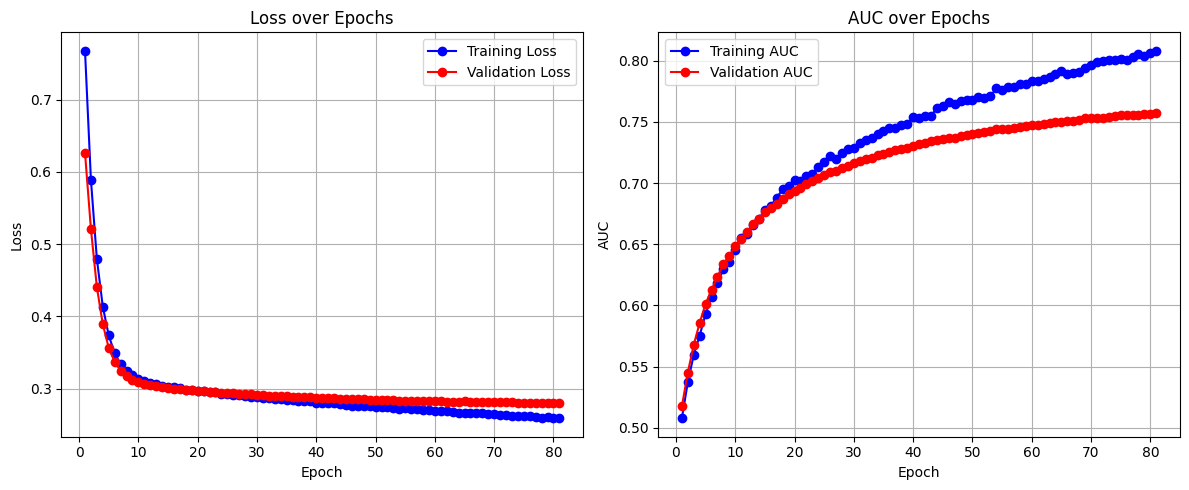

In [31]:
import matplotlib.pyplot as plt

history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['auc'], 'bo-', label='Training AUC')
plt.plot(epochs, history_dict['val_auc'], 'ro-', label='Validation AUC')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


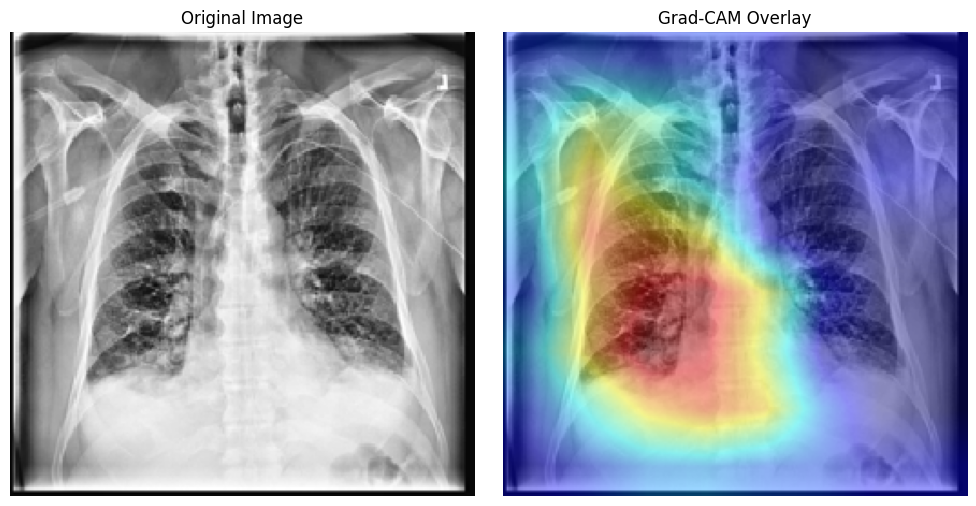

In [34]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()



def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    color_map = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(img, 1 - alpha, color_map, alpha, 0)
    return output


test_img_batch, test_label_batch = test_generator[0]  # First batch
test_img = test_img_batch[0]  # First image
img_array = np.expand_dims(test_img, axis=0)

original_img = (test_img * 255).astype("uint8")

last_conv_layer_name = "conv5_block16_2_conv"

target_class_index = 0 

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=target_class_index)

# Overlay heatmap on image
superimposed_img = overlay_heatmap(heatmap, original_img)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Overlay")
plt.imshow(superimposed_img[..., ::-1]) 
plt.axis("off")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


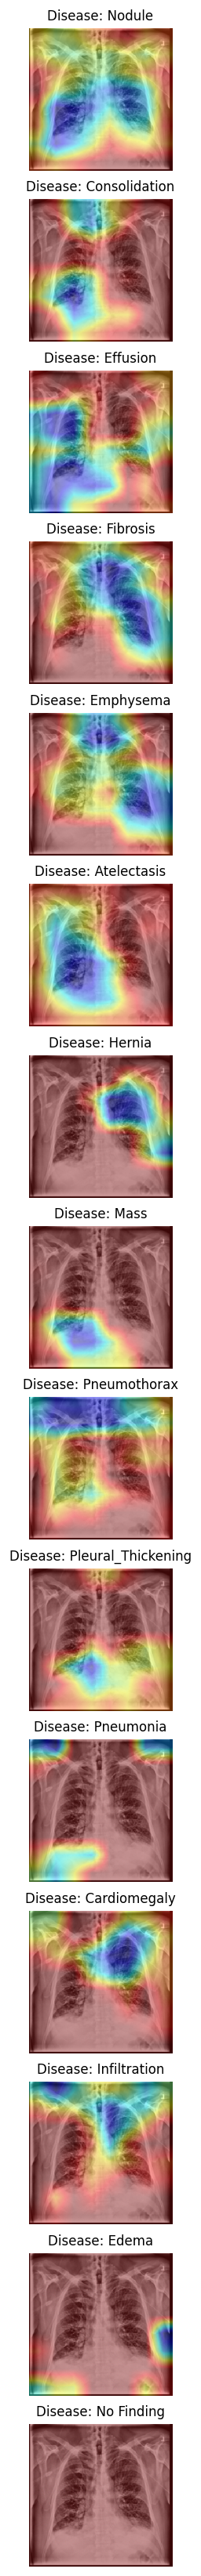

In [60]:
def make_gradcam_heatmap_for_classes(img_array, model, last_conv_layer_name, pred_indices=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    if pred_indices is None:
        predictions = model.predict(img_array)
        pred_indices = np.argsort(predictions[0])[::-1]

    heatmaps = []
    for class_idx in pred_indices:
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            class_channel = predictions[:, class_idx]

        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]

        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        heatmaps.append(heatmap.numpy())
    
    return heatmaps, pred_indices

def overlay_heatmaps_for_classes(heatmaps, img, pred_indices, disease_columns, alpha=0.4, colormap=cv2.COLORMAP_JET):
    fig, axes = plt.subplots(len(heatmaps), 1, figsize=(30, 30), dpi=120)
    if len(heatmaps) == 1:  
        axes = [axes]

    for i, heatmap in enumerate(heatmaps):
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        color_map = cv2.applyColorMap(heatmap_resized, colormap)

        output = cv2.addWeighted(img, 1 - alpha, color_map, alpha, 0)

        class_name = disease_columns[pred_indices[i]] 
        axes[i].imshow(output)
        axes[i].set_title(f"Disease: {class_name}", fontsize=10) 
        axes[i].axis('off')

    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.show()

test_img_batch, test_label_batch = test_generator[0]  
test_img = test_img_batch[0]  
img_array = np.expand_dims(test_img, axis=0)  

original_img = (test_img * 255).astype("uint8") 
last_conv_layer_name = "conv5_block16_2_conv"
heatmaps, pred_indices = make_gradcam_heatmap_for_classes(img_array, model, last_conv_layer_name, pred_indices=None)
overlay_heatmaps_for_classes(heatmaps, original_img, pred_indices, disease_columns, alpha=0.4, colormap=cv2.COLORMAP_JET)

In [62]:
import shap

Starting analysis...

Analyzing image 1/3

Detailed Predictions:
--------------------------------------------------
Disease              Score      Confidence Level
--------------------------------------------------
Nodule               0.3652    Medium
Mass                 0.2352    Low
Infiltration         0.1884    Low
Fibrosis             0.0987    Low
Pleural_Thickening   0.0710    Low
No Finding           0.0606    Low
Pneumonia            0.0562    Low
Pneumothorax         0.0343    Low
Atelectasis          0.0314    Low
Hernia               0.0305    Low
Cardiomegaly         0.0253    Low
Emphysema            0.0233    Low
Effusion             0.0215    Low
Consolidation        0.0193    Low
Edema                0.0092    Low
--------------------------------------------------


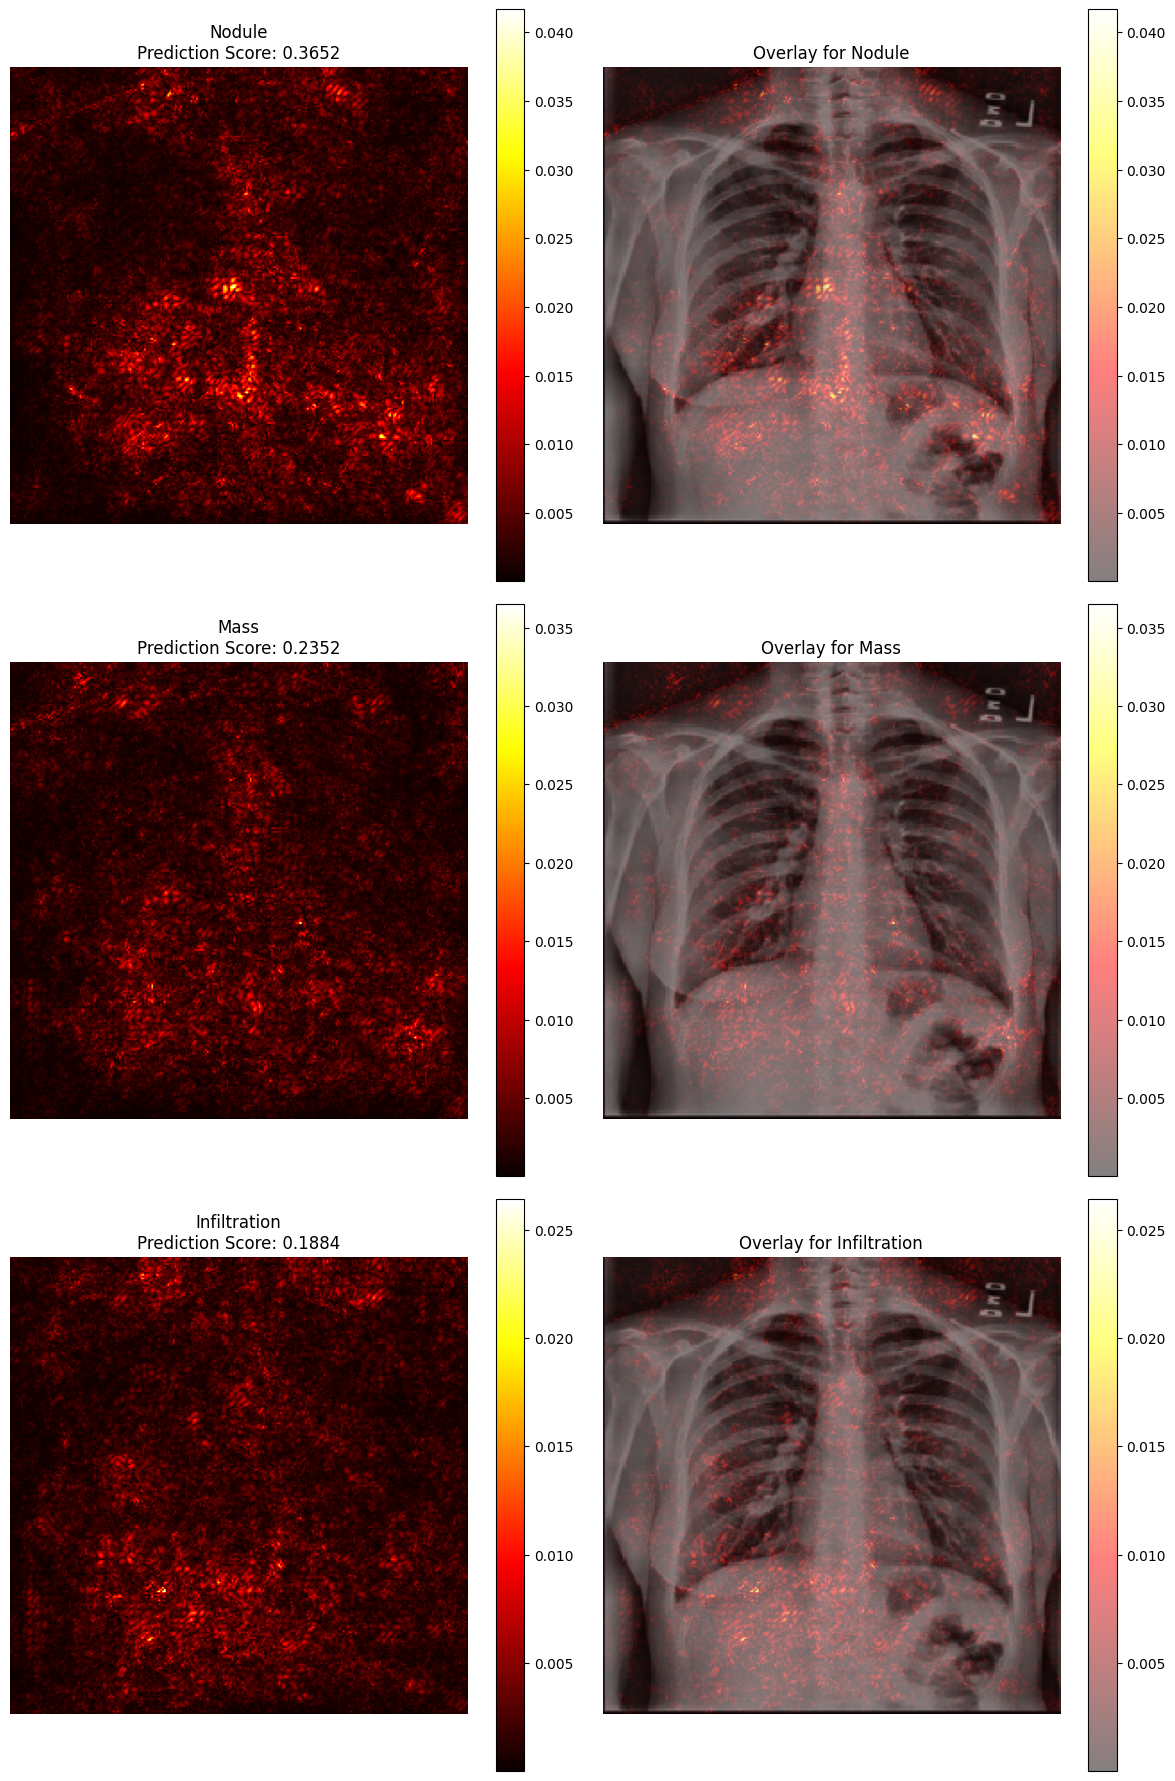


Ground Truth:
No Finding: 1

Analyzing image 2/3

Detailed Predictions:
--------------------------------------------------
Disease              Score      Confidence Level
--------------------------------------------------
Nodule               0.2750    Low
Pneumonia            0.2035    Low
Mass                 0.1485    Low
Infiltration         0.0989    Low
Atelectasis          0.0947    Low
No Finding           0.0903    Low
Consolidation        0.0461    Low
Emphysema            0.0316    Low
Cardiomegaly         0.0311    Low
Effusion             0.0275    Low
Hernia               0.0266    Low
Pleural_Thickening   0.0235    Low
Edema                0.0214    Low
Fibrosis             0.0200    Low
Pneumothorax         0.0193    Low
--------------------------------------------------


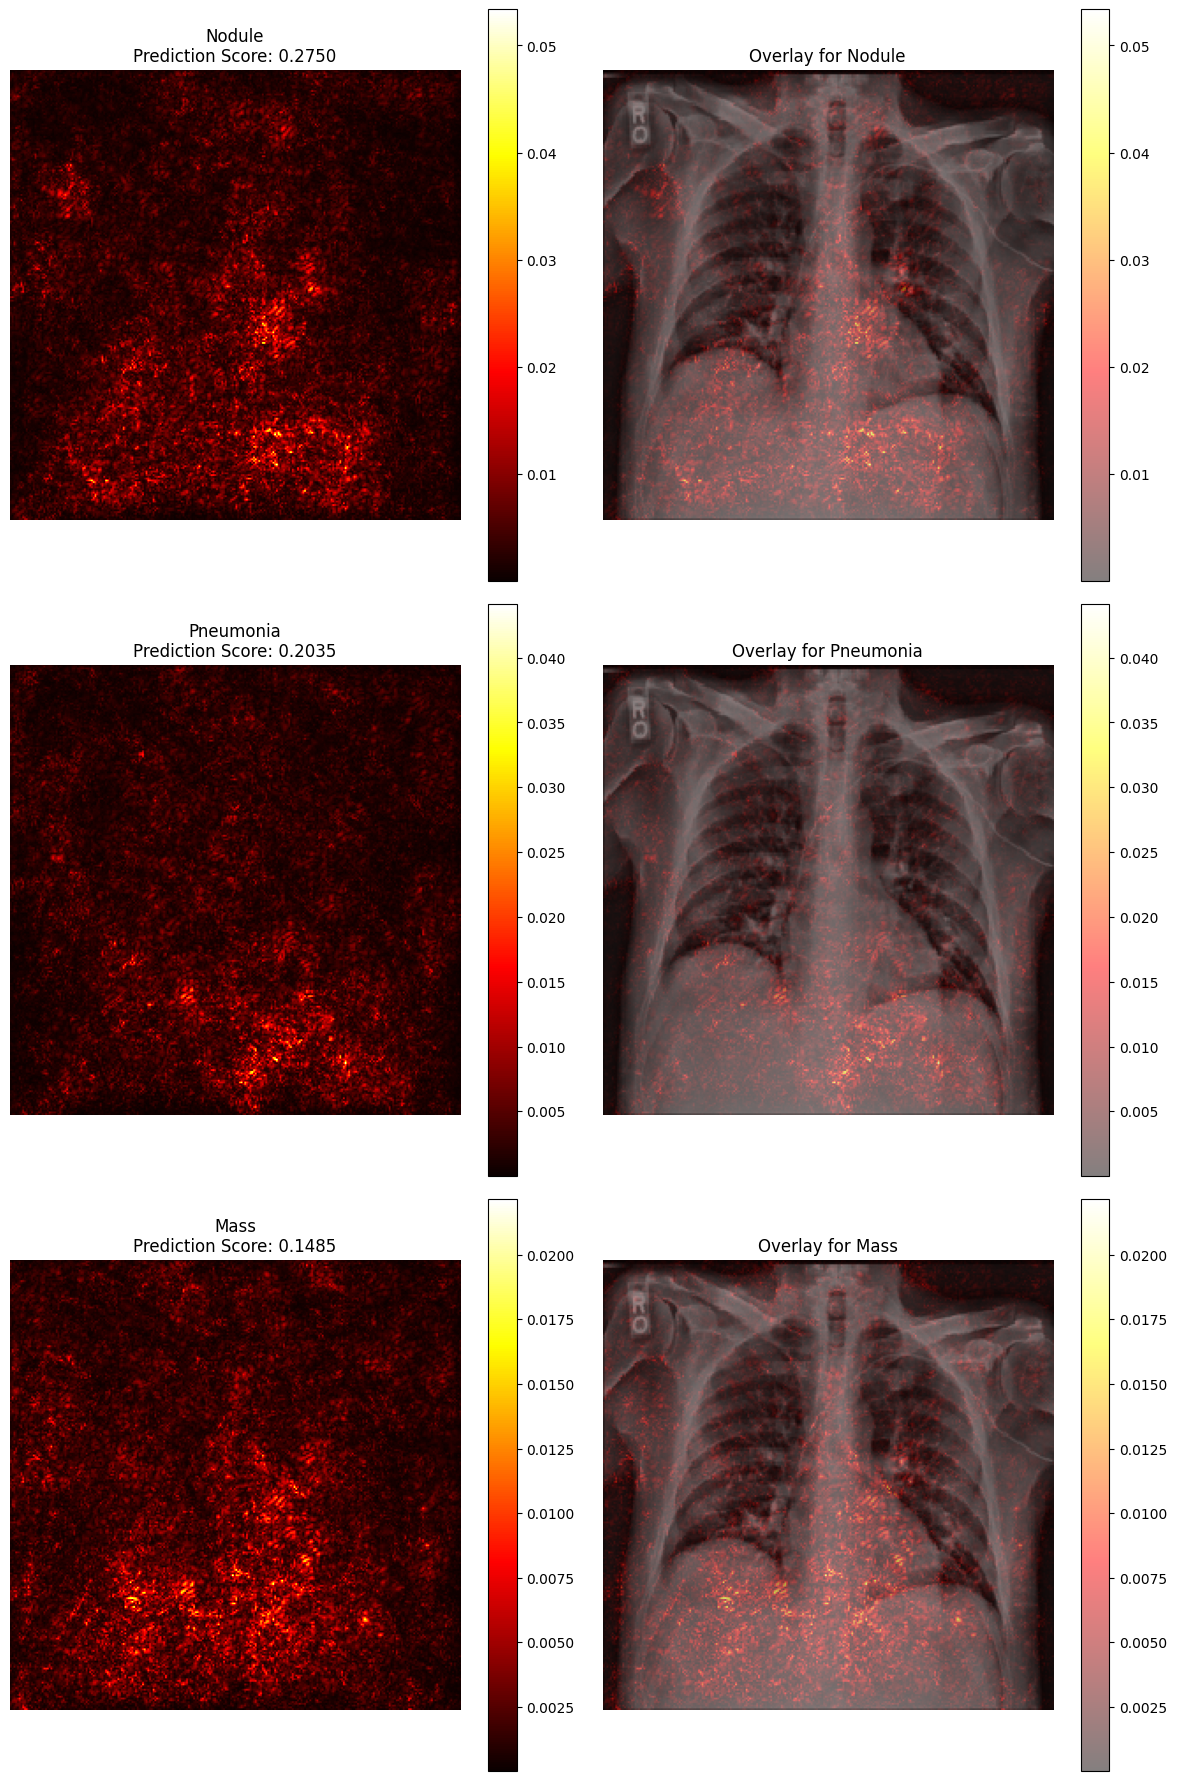


Ground Truth:
Atelectasis: 1

Analyzing image 3/3

Detailed Predictions:
--------------------------------------------------
Disease              Score      Confidence Level
--------------------------------------------------
Edema                0.2473    Low
Pneumonia            0.2195    Low
Emphysema            0.1513    Low
Atelectasis          0.1466    Low
Cardiomegaly         0.1412    Low
Consolidation        0.1387    Low
Hernia               0.1385    Low
Nodule               0.1279    Low
Mass                 0.1214    Low
Infiltration         0.1121    Low
Pneumothorax         0.0658    Low
Effusion             0.0645    Low
Fibrosis             0.0617    Low
Pleural_Thickening   0.0600    Low
No Finding           0.0042    Low
--------------------------------------------------


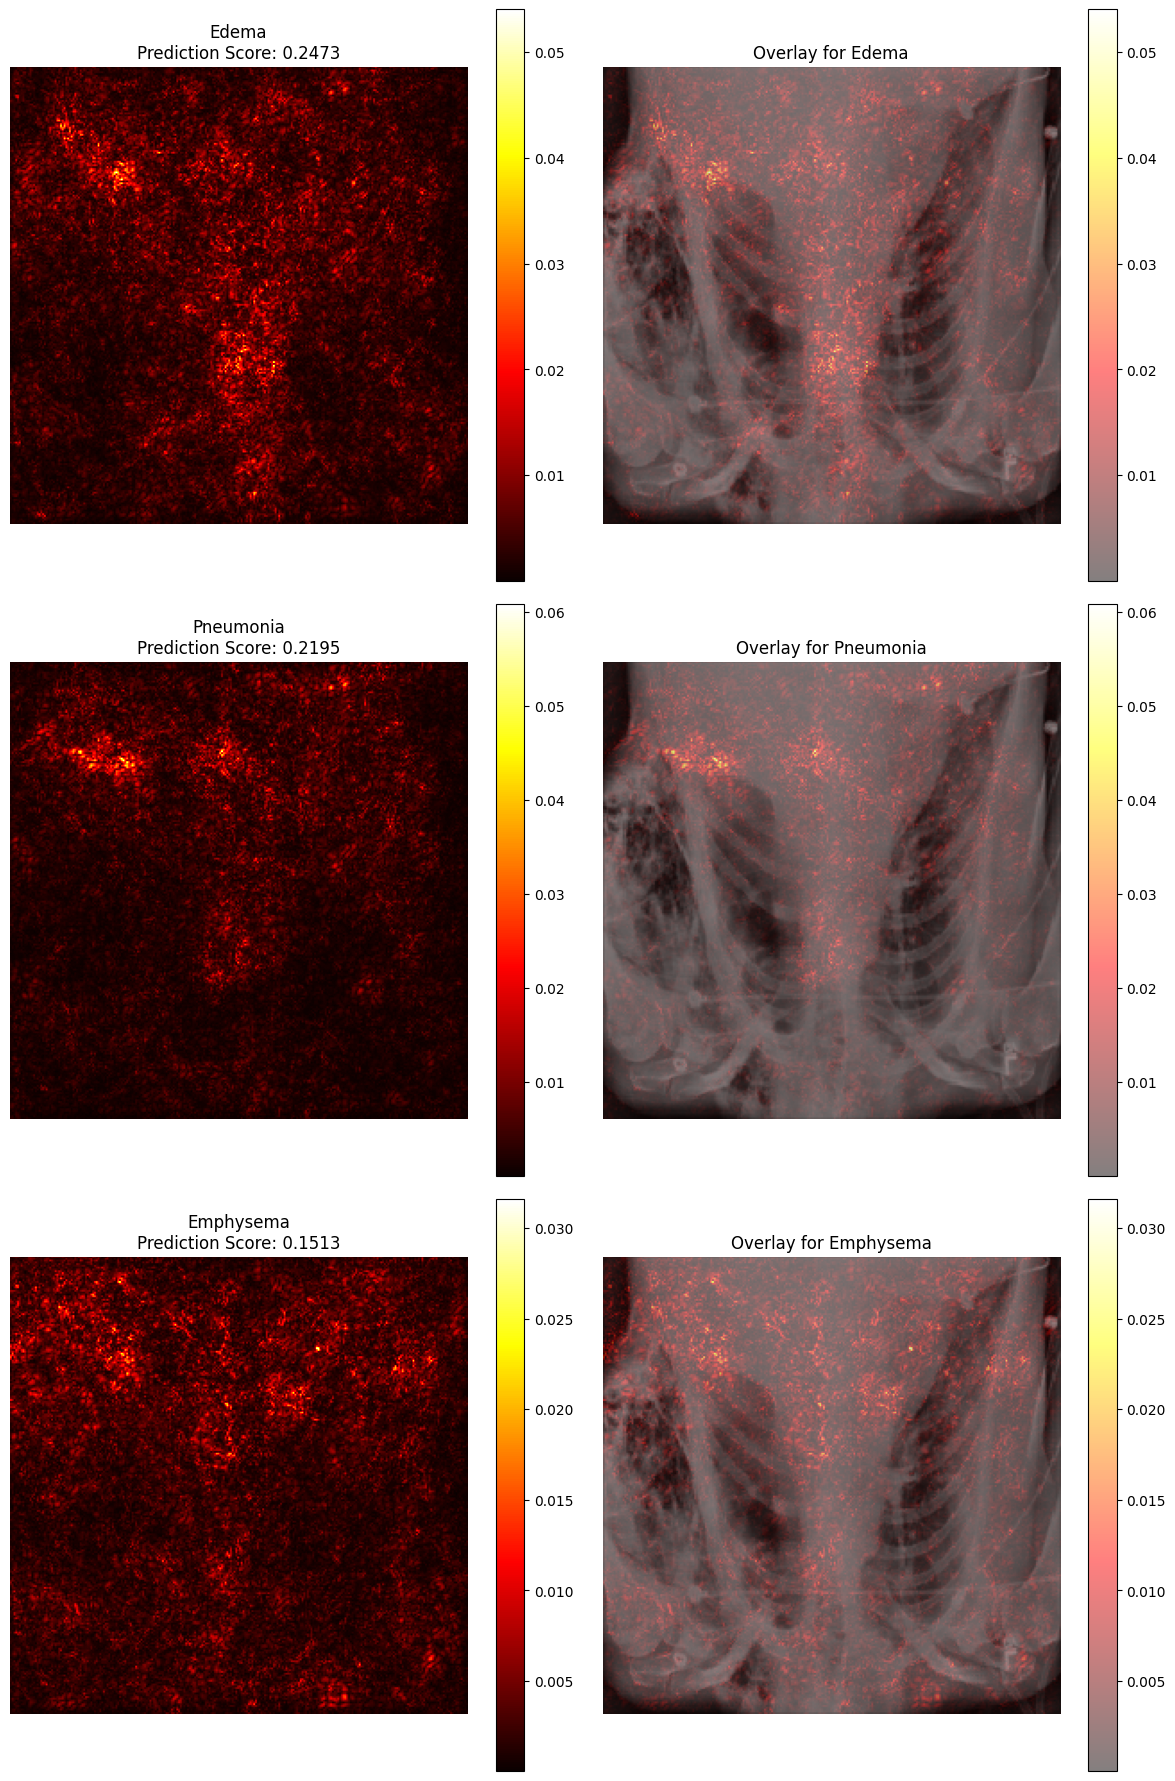


Ground Truth:
Emphysema: 1
Pleural_Thickening: 1
Pneumothorax: 1

Running statistical analysis...

Analyzing model statistics...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Model Statistics:
--------------------------------------------------
Atelectasis:
  Mean prediction: 0.0789
  Std deviation: 0.0575
Cardiomegaly:
  Mean prediction: 0.0823
  Std deviation: 0.0928
Consolidation:
  Mean prediction: 0.0708
  Std deviation: 0.0626
Edema:
  Mean prediction: 0.1265
  Std deviation: 0.1980
Effusion:
  Mean prediction: 0.0760
  Std deviation: 0.0723
Emphysema:
  Mean prediction: 0.1241
  Std deviation: 0.1250
Fibrosis:
  Mean prediction: 0.1042
  Std deviation: 0.1160
Hernia:
  Mean prediction: 0.1779
  Std deviation: 0.2614
Infiltration:
  Mean prediction: 0.1206
  Std deviation: 0.0952
Mass:
  Mean prediction: 0.1075
  Std deviation: 0.0757
No 

In [76]:
from tqdm import tqdm

def compute_gradients(model, images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        output = predictions[:, target_class_idx]
    return tape.gradient(output, images)

def explain_single_image(model, image, disease_columns):
    image = tf.convert_to_tensor(image)
    if len(image.shape) == 3:
        image = tf.expand_dims(image, 0)
    
    explanations = []
    predictions = model(image)
    
    for i in range(len(disease_columns)):
        grads = compute_gradients(model, image, i)
        grad_np = grads.numpy()
        attribution = np.mean(np.abs(grad_np), axis=-1)
        explanations.append(attribution)
        
    return explanations, predictions.numpy()[0]

def visualize_single_explanation(image, explanations, predictions, disease_columns, top_k=3):
    if isinstance(image, tf.Tensor):
        image = image.numpy()

    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    fig, axes = plt.subplots(top_k, 2, figsize=(12, 6 * top_k))
    
    for idx, disease_idx in enumerate(top_indices):
        disease = disease_columns[disease_idx]
        attribution = explanations[disease_idx][0]
        
        # Plot attribution map
        im1 = axes[idx, 0].imshow(attribution, cmap='hot')
        axes[idx, 0].set_title(f'{disease}\nPrediction Score: {predictions[disease_idx]:.4f}')
        plt.colorbar(im1, ax=axes[idx, 0])
        axes[idx, 0].axis('off')
        
        # Plot overlay
        axes[idx, 1].imshow(image[0])
        im2 = axes[idx, 1].imshow(attribution, cmap='hot', alpha=0.5)
        axes[idx, 1].set_title(f'Overlay for {disease}')
        plt.colorbar(im2, ax=axes[idx, 1])
        axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_predictions(predictions, disease_columns):
    sorted_indices = np.argsort(predictions)[::-1]
    
    print("\nDetailed Predictions:")
    print("-" * 50)
    print(f"{'Disease':<20} {'Score':<10} {'Confidence Level'}")
    print("-" * 50)
    
    for idx in sorted_indices:
        score = predictions[idx]
        confidence = ""
        if score > 0.7:
            confidence = "High"
        elif score > 0.3:
            confidence = "Medium"
        else:
            confidence = "Low"
        
        print(f"{disease_columns[idx]:<20} {score:.4f}    {confidence}")
    
    print("-" * 50)

def analyze_test_batch(model, test_generator, disease_columns, n_samples=3):
    try:
        test_batch = next(test_generator)
        test_images, test_labels = test_batch
        
        for i in range(min(n_samples, len(test_images))):
            print(f"\nAnalyzing image {i+1}/{n_samples}")
            print("=" * 50)
            
            image = test_images[i:i+1]
            
            try:
                explanations, predictions = explain_single_image(model, image, disease_columns)
                
                analyze_predictions(predictions, disease_columns)
                
                visualize_single_explanation(image, explanations, predictions, disease_columns)
                
                if test_labels is not None:
                    print("\nGround Truth:")
                    true_labels = test_labels[i]
                    for j, (disease, label) in enumerate(zip(disease_columns, true_labels)):
                        if label > 0:
                            print(f"{disease}: {label}")
                
            except Exception as e:
                print(f"Error analyzing image {i+1}: {str(e)}")
                continue
            
    except Exception as e:
        print(f"Error getting test batch: {str(e)}")
        return

def clear_memory():
    tf.keras.backend.clear_session()
    import gc
    gc.collect()

print("Starting analysis...")
try:
    analyze_test_batch(model, test_generator, disease_columns, n_samples=3)
except Exception as e:
    print(f"Error in analysis: {str(e)}")
finally:
    clear_memory()

def analyze_model_statistics(model, test_generator, disease_columns, n_batches=5):
    all_predictions = []
    all_labels = []
    
    print("\nAnalyzing model statistics...")
    for _ in range(n_batches):
        batch = next(test_generator)
        predictions = model.predict(batch[0])
        all_predictions.append(predictions)
        all_labels.append(batch[1])
    
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    
    print("\nModel Statistics:")
    print("-" * 50)
    for i, disease in enumerate(disease_columns):
        mean_pred = np.mean(all_predictions[:, i])
        std_pred = np.std(all_predictions[:, i])
        print(f"{disease}:")
        print(f"  Mean prediction: {mean_pred:.4f}")
        print(f"  Std deviation: {std_pred:.4f}")
    
    return all_predictions, all_labels

print("\nRunning statistical analysis...")
try:
    analyze_model_statistics(model, test_generator, disease_columns)
except Exception as e:
    print(f"Error in statistical analysis: {str(e)}")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

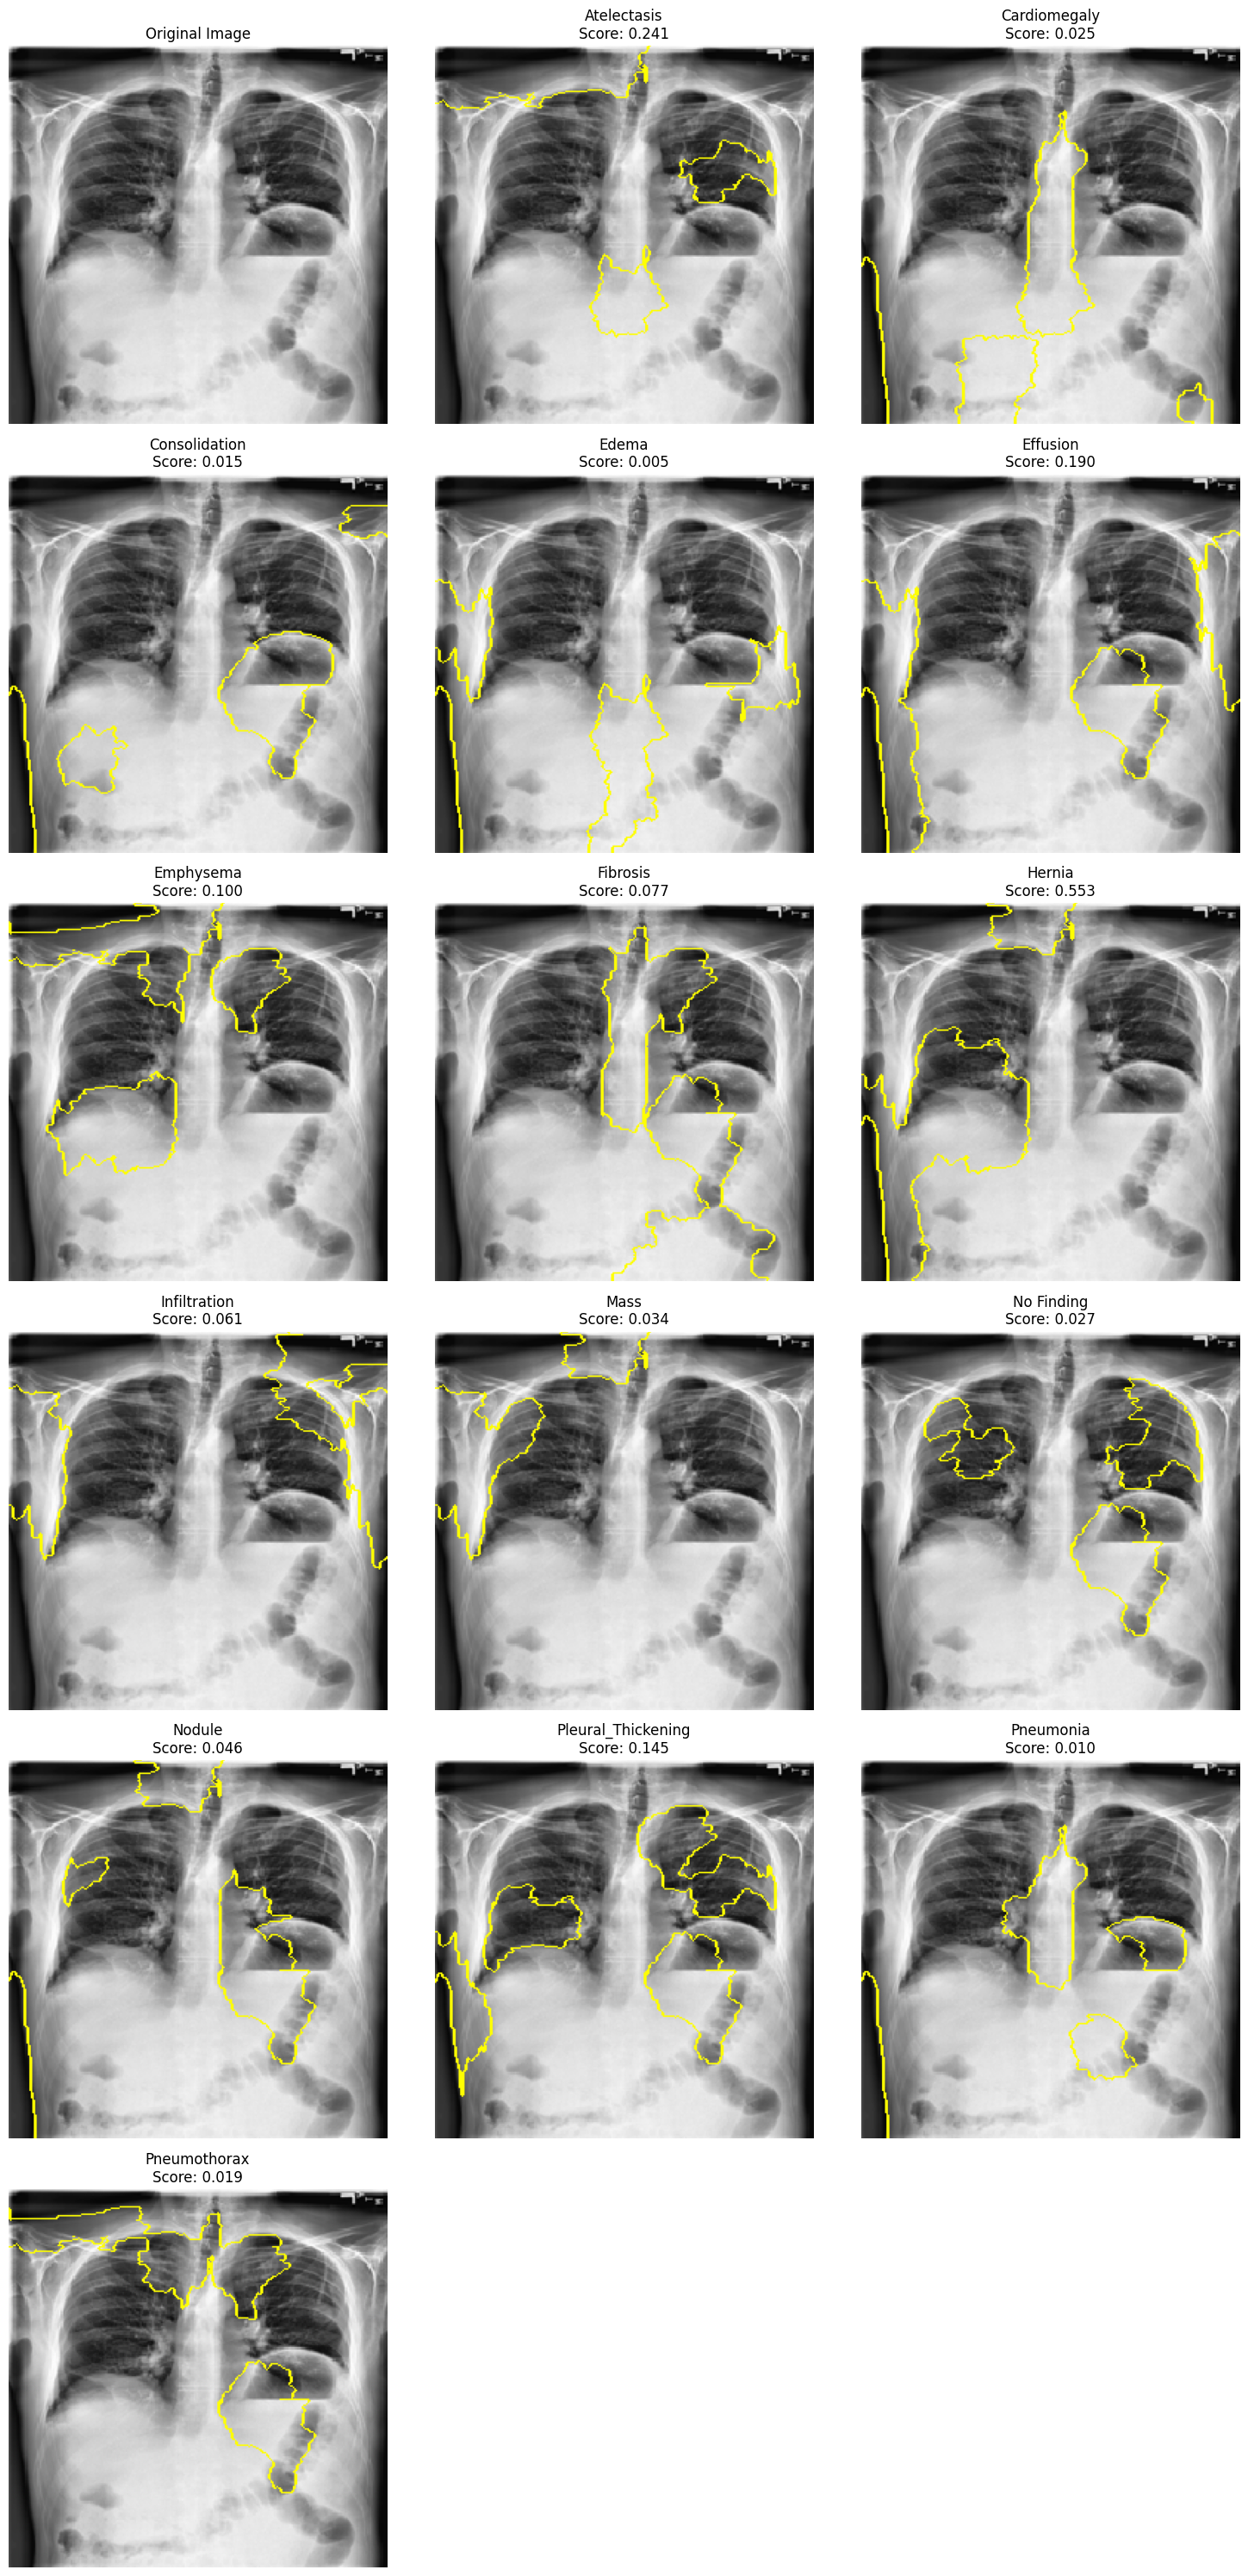

In [84]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
def get_model_predictions(images):
    return model.predict(images)

explainer = lime_image.LimeImageExplainer()

test_batch = next(test_generator)
test_image = test_batch[0][0]

explanation = explainer.explain_instance(
    test_image, 
    get_model_predictions,
    top_labels=len(disease_columns),
    hide_color=None,
    num_samples=1000
)

predictions = get_model_predictions(np.expand_dims(test_image, axis=0))[0]

n_cols = 3
n_rows = (len(disease_columns) + n_cols) // n_cols
plt.figure(figsize=(15, 5 * n_rows))

plt.subplot(n_rows, n_cols, 1)
plt.imshow(test_image)
plt.title('Original Image')
plt.axis('off')

for idx, disease in enumerate(disease_columns):
    temp, mask = explanation.get_image_and_mask(
        idx,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    
    plt.subplot(n_rows, n_cols, idx + 2) 
    plt.imshow(mark_boundaries(test_image, mask))
    plt.title(f'{disease}\nScore: {predictions[idx]:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()